In [1]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

In [2]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                       ]))

In [3]:
import torch

batch_size_train = 64
batch_size_test = 1000

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [4]:
examples = enumerate(data_loader_train)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data[0][0])
example_data[0][0].shape

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

torch.Size([28, 28])

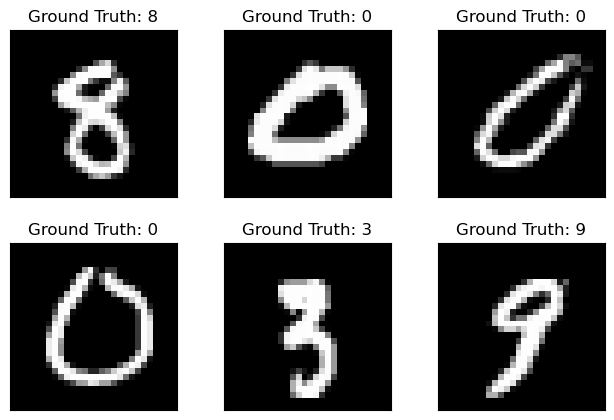

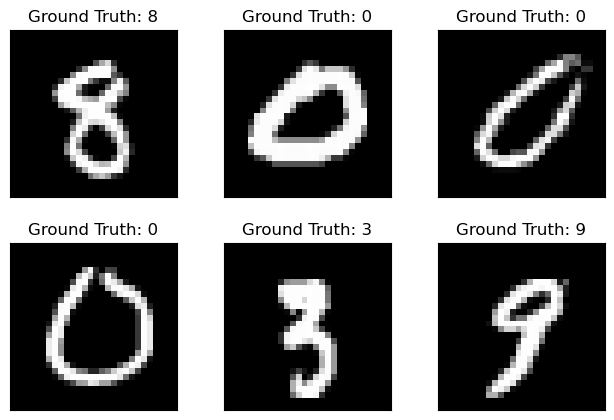

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
input_size = 1*28*28      
hidden1 = 64      
hidden2 = 64
hidden3 = 64
weight_bit_width = 2
act_bit_width = 2
num_classes = 10  

In [7]:
import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn
from torch.nn import Module

# Setting seeds for reproducibility
torch.manual_seed(0)

class LowPrecisionMLP(Module):
    def __init__(self):
        super(LowPrecisionMLP, self).__init__()
        
        self.fc1   = qnn.QuantLinear(input_size, hidden1, bias=True, weight_bit_width=weight_bit_width)
        self.bn1   = nn.BatchNorm1d(hidden1)
        self.dp1   = nn.Dropout(0.5)
        self.relu1 = qnn.QuantReLU(bit_width=act_bit_width)
        
        self.fc2   = qnn.QuantLinear(hidden1, hidden2, bias=True, weight_bit_width=weight_bit_width)
        self.bn2   = nn.BatchNorm1d(hidden2)
        self.dp2   = nn.Dropout(0.5)
        self.relu2 = qnn.QuantReLU(bit_width=act_bit_width)
        
        self.fc3   = qnn.QuantLinear(hidden2, hidden3, bias=True, weight_bit_width=weight_bit_width)
        self.bn3   = nn.BatchNorm1d(hidden3)
        self.dp3   = nn.Dropout(0.5)
        self.relu3 = qnn.QuantReLU(bit_width=act_bit_width)
        
        self.out   = qnn.QuantLinear(hidden3, num_classes, bias=True, weight_bit_width=weight_bit_width)

    def forward(self, x):
        out = x.reshape(x.shape[0], -1)
        out = self.relu1(self.dp1(self.bn1(self.fc1(out))))
        out = self.relu2(self.dp2(self.bn2(self.fc2(out))))
        out = self.relu3(self.dp3(self.bn3(self.fc3(out))))
        out = self.out(out)
        return out
    
model = LowPrecisionMLP()

In [8]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target)
        
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        
        optimizer.zero_grad()
        loss = criterion(outputs,target)
 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.numpy()) 
           
    return losses

In [9]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = Variable(inputs),Variable(target)
            output_orig = model(inputs)
            #output_orig = model(inputs.float())
            # run the output through sigmoid
            output = torch.sigmoid(output_orig)  
            _, pred = torch.max(outputs,1)
            testing_correct += torch.sum(pred == y_test.data)
            # compare against a threshold of 0.5 to generate 0/1
            pred = (output.detach().numpy() > 0.5) * 1
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [10]:
num_epochs = 10
learn_rate = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [11]:
# loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss:   0%|                                                                                                                                                                        | 0/10 [00:20<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [10000, 100000]